In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from fastai.text import *
import html
import json

import pandas as pd
import numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(42)

pd.option_context('display.max_rows', None, 'display.max_columns', None)
np.set_printoptions(threshold=np.nan)


In [2]:
DATA_PATH=Path('./data/election_tweets')

PRE_FINETUNE_PATH=Path('./LM_fine_tune')

TWEETSLM_PATH=Path('./LM_tweets')

CLAS_PATH=Path('./tweets_class')

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [3]:
chunksize=24000

re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

## Load Encoder Weights for Language Model

In [4]:
BACKBONE_MODEL = PRE_FINETUNE_PATH/'models/lm1_wgts.h5'

In [5]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [6]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [7]:
itos2 = pickle.load((PRE_FINETUNE_PATH/'tmp'/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [8]:
em_sz,nh,nl = 400,1150,3

In [9]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))

In [10]:
vs=len(itos)
vs,len(trn_lm)

(2164, 2804)

In [11]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [12]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [13]:
wd=1e-7
bptt=70
bs=16
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [14]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [15]:
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(TWEETSLM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [16]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*1.0

In [17]:
learn = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [18]:
learn.model.load_state_dict(wgts)

In [19]:
learn.lr_find2(start_lr=1e-1,end_lr=3e-1, num_it=300)

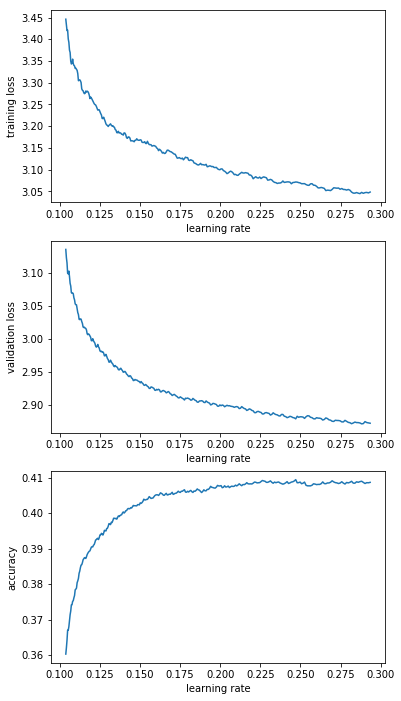

In [20]:
learn.sched.plot()

In [21]:
lr= 0.150
lrs = lr

In [22]:
learn.clip=0.12

In [23]:
learn.fit(lr, 1, cycle_len=10, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy                 
    0      3.228649   2.952163   0.393347  
    1      3.162104   2.921555   0.404155                 
    2      3.125755   2.887652   0.407887                 
    3      3.101368   2.873209   0.412174                 
    4      3.066031   2.860357   0.41419                  
    5      3.055062   2.854706   0.414336                 
    6      3.041896   2.856517   0.416431                 
    7      3.046383   2.850184   0.417447                 
    8      3.034916   2.848639   0.416466                 
    9      3.035166   2.848087   0.416718                 


[array([2.84809]), 0.4167176031833173]

In [24]:
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')

## Classifier tokens

In [34]:
itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

2164

In [35]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [36]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [37]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 96

In [38]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a tweet at a time. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie tweets, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [39]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(TWEETSLM_PATH, trn_dl, val_dl, test_dl=val_dl)

In [44]:
#dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.8
dps = np.array([0.4,0.5,0.05,0.3,0.4])

In [45]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [46]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [47]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

In [48]:
#wd = 1e-7
learn.load_encoder('lm1_enc')

In [49]:
learn.freeze_to(-1)

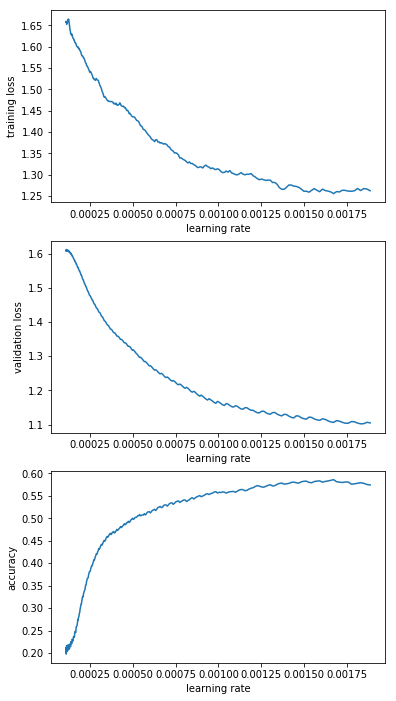

In [50]:
learn.lr_find2(start_lr=1e-4,end_lr=2e-3, num_it=300)
learn.sched.plot()

In [51]:
lr= 6e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [54]:
learn.fit(lrs, 4, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7), best_save_name='clas2_0')

epoch      trn_loss   val_loss   accuracy                 
    0      1.187077   0.995345   0.644632  
    1      1.176462   1.002811   0.648652                 
    2      1.192143   1.009812   0.638088                 
    3      1.186899   0.993638   0.625083                 


[array([0.99364]), 0.6250831879073788]

In [55]:
learn.load('clas2_0')

In [56]:
learn.freeze_to(-2)

In [57]:
learn.fit(lrs, 8, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7),  best_save_name='clas2_1')

epoch      trn_loss   val_loss   accuracy                 
    0      1.148129   1.005992   0.6532    
    1      1.134067   1.022656   0.602743                 
    2      1.125098   0.976759   0.657147                 
    3      1.174397   0.983822   0.659836                 
    4      1.127286   0.983982   0.646138                 
    5      1.099076   0.982436   0.637829                 
    6      1.116796   0.968375   0.648421                 
    7      1.08232    0.974003   0.660104                 


[array([0.974]), 0.6601042516113068]

In [58]:
learn.load('clas2_1')

In [59]:
learn.unfreeze()

In [61]:
learn.fit(lr, 1, cycle_len=10, use_clr_beta=(32,10,0.8,0.7), best_save_name='final')

epoch      trn_loss   val_loss   accuracy                  
    0      1.028508   0.913798   0.645648  
    1      0.986357   0.911867   0.642515                  
    2      0.951645   0.918216   0.639881                  
    3      0.851348   0.888579   0.626516                  
    4      0.78501    0.889561   0.661334                  
    5      0.707746   0.881598   0.659106                  
    6      0.666266   0.877898   0.647765                  
    7      0.605308   0.877732   0.6344                    
    8      0.593287   0.912321   0.638051                  
    9      0.590345   0.895031   0.639715                  


[array([0.89503]), 0.6397145918067197]

In [62]:
#learn.load('final')
#learn.sched.plot_loss()

## Model Evaluation

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

F1(macro) =  0.7026971368599696
Accuracy  =  0.717948717948718


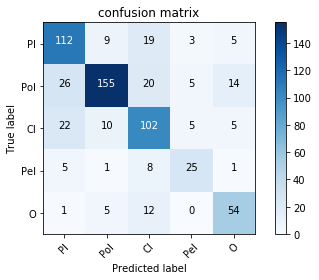

In [6]:
bs = 256
bptt,em_sz,nh,nl = 70,400,1150,3

tst_sent = np.load(CLAS_PATH/'tmp/tst_ids.npy')
tst_lbls = np.load(CLAS_PATH/'tmp/tst_labels.npy').flatten()
tst_lbls -= tst_lbls.min()
c=int(tst_lbls.max())+1
tst_ds = TextDataset(tst_sent, tst_lbls)
tst_samp = SortSampler(tst_sent, key=lambda x: len(tst_sent[x]))
tst_lbls_sampled = tst_lbls[list(tst_samp)]
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=tst_samp)
md = ModelData(TWEETSLM_PATH, None, tst_dl)
itos = pickle.load(open(TWEETSLM_PATH/'tmp/itos.pkl', 'rb'))
vs = len(itos)
    
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
                layers=[em_sz*3, 50, c], drops=[0., 0.])

learn = RNN_Learner(md, TextModel(to_gpu(m)))
learn.load_encoder('lm1_enc')
learn.load('final')
predictions = np.argmax(learn.predict(), axis=1)

f1 = f1_score(tst_lbls_sampled, predictions, average='macro')
print('F1(macro) = ', f1)

acc = (tst_lbls_sampled == predictions).mean()
print('Accuracy  = ', acc)


cnf_matrix = confusion_matrix(tst_lbls_sampled, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PI', 'PoI', 'CI', 'PeI', 'O'], title='confusion matrix')
plt.show()

# EDA

In [36]:
df = pd.DataFrame({'tokens':tst_sent, 
                   'actual': tst_lbls_sampled , 
                   'prediction': predictions})




In [37]:
PI =df.loc[df['actual']==1]
PI['prediction'].value_counts()

0    112
2     19
1      9
4      5
3      3
Name: prediction, dtype: int64